C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


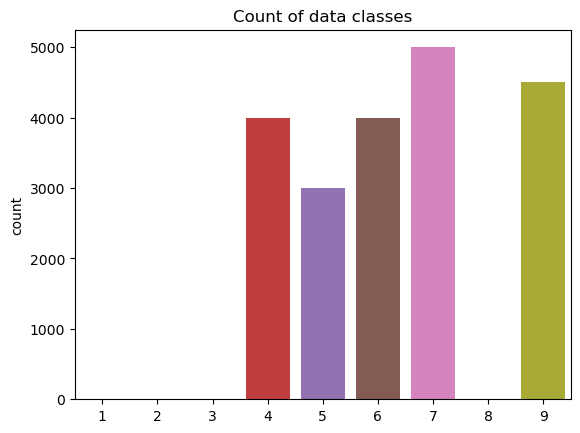

In [5]:
import flwr as fl
import tensorflow as tf
from tensorflow import keras
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

def getDist(y):
    ax = sns.countplot(y)
    ax.set(title="Count of data classes")
    plt.show()

def getData(dist, x, y):
    dx = []
    dy = []
    counts = [0 for i in range(10)]
    for i in range(len(x)):
        if counts[y[i]]<dist[y[i]]:
            dx.append(x[i])
            dy.append(y[i])
            counts[y[i]] += 1
        
    return np.array(dx), np.array(dy)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(10, activation='softmax'))
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
dist = [0, 10, 10, 10, 4000, 3000, 4000, 5000, 10, 4500]
x_train, y_train = getData(dist, x_train, y_train)
getDist(y_train)


In [6]:
class FlowerClient(fl.client.NumPyClient):
    def get_parameters(self,config):
        return model.get_weights()

    def fit(self, parameters, config):
        model.set_weights(parameters)
        r = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_test, y_test), verbose=1)
        hist = r.history
        print("Fit history : " ,hist)
        return model.get_weights(), len(x_train), {}

    def evaluate(self, parameters, config):
        model.set_weights(parameters)
        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        print("Eval accuracy : ", accuracy)
        return loss, len(x_test), {"accuracy": accuracy}

PORT=5010
fl.client.start_numpy_client(
        server_address="localhost:"+str(PORT), 
        client=FlowerClient(), 
        grpc_max_message_length = 1024*1024*1024
)

INFO flower 2023-11-28 23:44:54,813 | connection.py:102 | Opened insecure gRPC connection (no certificates were passed)
DEBUG flower 2023-11-28 23:44:54,842 | connection.py:39 | ChannelConnectivity.IDLE
DEBUG flower 2023-11-28 23:44:54,859 | connection.py:39 | ChannelConnectivity.READY


Epoch 1/10
321/321 [==============================] - 8s 18ms/step - loss: 0.2552 - accuracy: 0.9244 - val_loss: 3.2643 - val_accuracy: 0.4686
Epoch 2/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0887 - accuracy: 0.9735 - val_loss: 2.2213 - val_accuracy: 0.4957
Epoch 3/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0541 - accuracy: 0.9825 - val_loss: 2.5290 - val_accuracy: 0.5240
Epoch 4/10
321/321 [==============================] - 6s 18ms/step - loss: 0.0366 - accuracy: 0.9881 - val_loss: 2.3765 - val_accuracy: 0.6165
Epoch 5/10
321/321 [==============================] - 5s 17ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 2.3849 - val_accuracy: 0.6285
Epoch 6/10
321/321 [==============================] - 3s 10ms/step - loss: 0.0169 - accuracy: 0.9950 - val_loss: 2.6958 - val_accuracy: 0.6128
Epoch 7/10
321/321 [==============================] - 6s 17ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 2.9265 - val_accuracy: 0.6253

DEBUG flower 2023-11-28 23:48:00,847 | connection.py:121 | gRPC channel closed
INFO flower 2023-11-28 23:48:00,853 | app.py:149 | Disconnect and shut down


Eval accuracy :  0.9363999962806702
